<a href="https://colab.research.google.com/github/cwlanyon/CardiacDTWorkshop/blob/main/Gaussian_Process_Emulators_For_Cardiac_Digital_Twins_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with Gaussian process emulators !!

This lab is designed to introduce Gaussian process emulation in a practical way using the Python package GPyTorch and the Modular Circ cardiac model.

This lab session is intended to be introductory in nature due to the varied scientific backgrounds of the attendees. It involves visualising samples from Gaussian process priors, loading and normalising a datasets, learning a GP surrogate function for a cardiac digital twin and testing different GP kernel functions to assess emulator accuracy.

In [116]:
!pip install gpytorch

In [117]:
!pip install ModularCirc

In [118]:

# Support for maths
import numpy as np
import torch

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

# For splitting training and testing data
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# For running the Modular Circ cardiac digital twin
import ModularCirc

#GpyTorch Gaussian Process library
import gpytorch as gpt


# Displaying images from URLs
from PIL import Image
from IPython.display import display
import urllib.request
from io import BytesIO

The documentation for GPyTorch is avilable at https://docs.gpytorch.ai/en/stable/. We will be using GPyTorch to define our kernels, mean functions and GP models. Training the GP models is done externally using the ADAM optimiser in pytorch.

### Covariance functions, aka kernels

We will define a covariance function, from hereon referred to as a kernel, using `GPyTorch`. The most commonly used kernel in machine learning is the Gaussian-form radial basis function (RBF) kernel. It is also commonly referred to as the exponentiated quadratic or squared exponential kernel &ndash; all are equivalent.

The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:

$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$

It has two parameters, described as the variance, $\sigma^2$ and the lengthscale $\mathscr{l}$.

In GPyTorch, we define our kernels using kernel modules. To build a kernel with both lengthscale and variance parameters we need to wrap RBFKernel function inside of a ScaleKernel (this provides the variance parameter, $\sigma^2$).

In [119]:
# Here we define an RBF kernel with both lengthscale and variance parameters
RBF_covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel())

This kernel has been instantiated with the default parameters, we can check them by calling them from the covariance module.

Note that, because we generated our kernel by wrapping an unscaled RBF inside a scale kernel, to call the lengthscale we need to use the "base_kernel" argument.

In [120]:
RBF_covar_module.outputscale

tensor(0.6931, grad_fn=<SoftplusBackward0>)

In [121]:
RBF_covar_module.base_kernel.lengthscale

tensor([[0.6931]], grad_fn=<SoftplusBackward0>)

If we want to change the kernel variables we can set them ourselves

In [122]:
RBF_covar_module.outputscale=1
RBF_covar_module.base_kernel.lengthscale=1

print("The variance is now",RBF_covar_module.outputscale.tolist(),"and the lengthscale is now",RBF_covar_module.base_kernel.lengthscale.tolist())

The variance is now 1.0 and the lengthscale is now [[1.0]]


### Visualising the kernel

We can visualise our kernel in a few different ways. We can plot the _shape_ of the kernel by plotting $k(x,0)$ over some sample space $x$ which, looking at the equation above, clearly has a Gaussian shape. This describes the covariance between each sample location and $0$.

Alternatively, we can construct a full covariance matrix, $\mathbf{K}_{xx} \triangleq k(x,x')$ (with samples $x = x'$, generating a diagonal matrix). The resulting GP prior is a multivariate normal distribution over the space of samples $x$: $N(\mathbf{0}, \mathbf{K}_{xx})$. It should be evident then that the elements of the matrix represents the covariance between respective points in $x$ and $x'$, and that it is exactly $\sigma^2[=1]$ in the diagonal.

We can show this using `pyplot` to plot the vector $k(x,0)$ and the matrix $k(x,x')$:

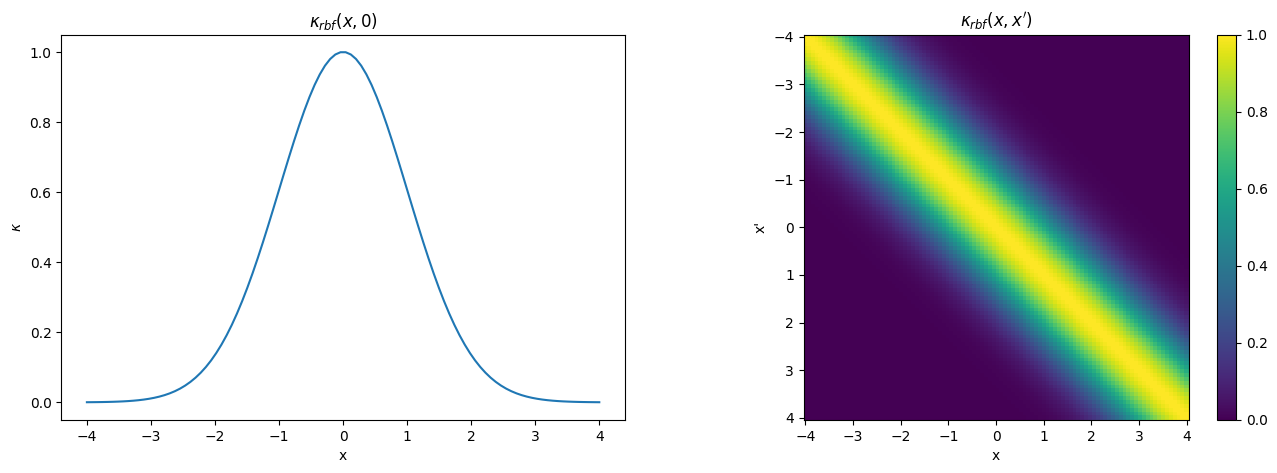

In [123]:
# Our sample space: 100 samples in the interval [-4,4]
x1 = torch.linspace(-4.,4.,100) # we need [:, None] to reshape X into a column vector for use in GPy

covar_1D = RBF_covar_module(x1,torch.tensor([0])) # Returns a RootLinearOperator
tensor_1D = covar_1D.to_dense().detach().numpy()  # Gets the actual tensor for this kernel matrix, we use detach().numpy() to remove

covar_2D = RBF_covar_module(x1) # Returns a RootLinearOperator
tensor_2D = covar_2D.to_dense().detach().numpy() # Gets the actual tensor for this kernel matrix

# Set up the plotting environment
plt.figure(figsize=(16,5))

# ==== k(x,0)

plt.subplot(121) # left plot

# Plot covariance vector
plt.plot(x1.detach().numpy(),tensor_1D)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.title("$\kappa_{rbf}(x,0)$")

# ==== k(x,x')

plt.subplot(122) # right plot

# Plot the covariance of the sample space
plt.pcolor(x1.T.detach().numpy(), x1.detach().numpy(), tensor_2D)

# Format and annotate plot
plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("$\kappa_{rbf}(x,x')$");

We can also visualise how the kernel parameters affect the kernel function, below we vary the lengthscale, $l$:

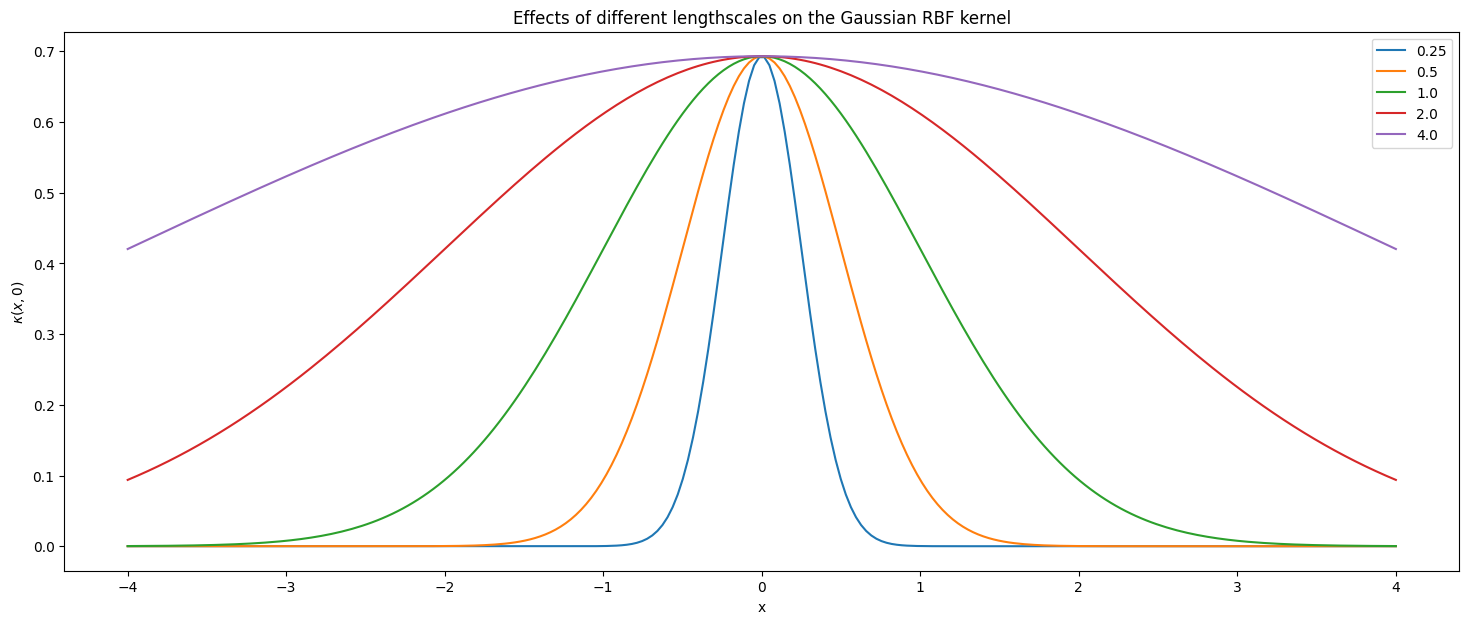

In [124]:
# Our sample space : 100 samples in the interval [-4,4]
X = torch.linspace(-4.,4.,250) # we use more samples to get a smoother plot at low lengthscales

# Create a 1-D RBF kernel with default parameters
k = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel())

# Set up the plotting environment
plt.figure(figsize=(18, 7))

# Set up our list of different lengthscales
ls = [0.25, 0.5, 1., 2., 4.]

# Loop over the lengthscale values
for l in ls:
    # Set the lengthscale to be l
    k.base_kernel.lengthscale = l
    # Calculate the new covariance function at k(x,0)
    covar_1D = k(X,torch.tensor([0])) # Returns a RootLinearOperator
    C= covar_1D.to_dense().detach().numpy()
    # Plot the resulting covariance vector
    plt.plot(X,C)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa(x,0)$")
plt.title("Effects of different lengthscales on the Gaussian RBF kernel")
plt.legend(labels=ls);

### Exercise 1

(a) What is the effect of the lengthscale parameter on the covariance function?

(b) Change the code used above to plot the covariance function showing the effects of the variance on the covariance function. Comment on the effect.

## 2. Types of covariance function

There are many different covariance functions already implemented in `GPy`. Aside from the `RBF` kernel, there are others such as the following:
- `Cosine`
- `Matern`
- `Polynomial`
- `Linear`

You can also combine kernels using the `additive` and `structure` kernels. Adding and multiplying kernels can be acheived simply by using the "+" and "*" operators.

See the docs here: https://docs.gpytorch.ai/en/v1.14/kernels.html

Note: when defining these, all are preceded by `gpt.kernels.` The following are some examples of the [Matérn 5/2](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) and Cosine kernels, compared with the RBF kernel:

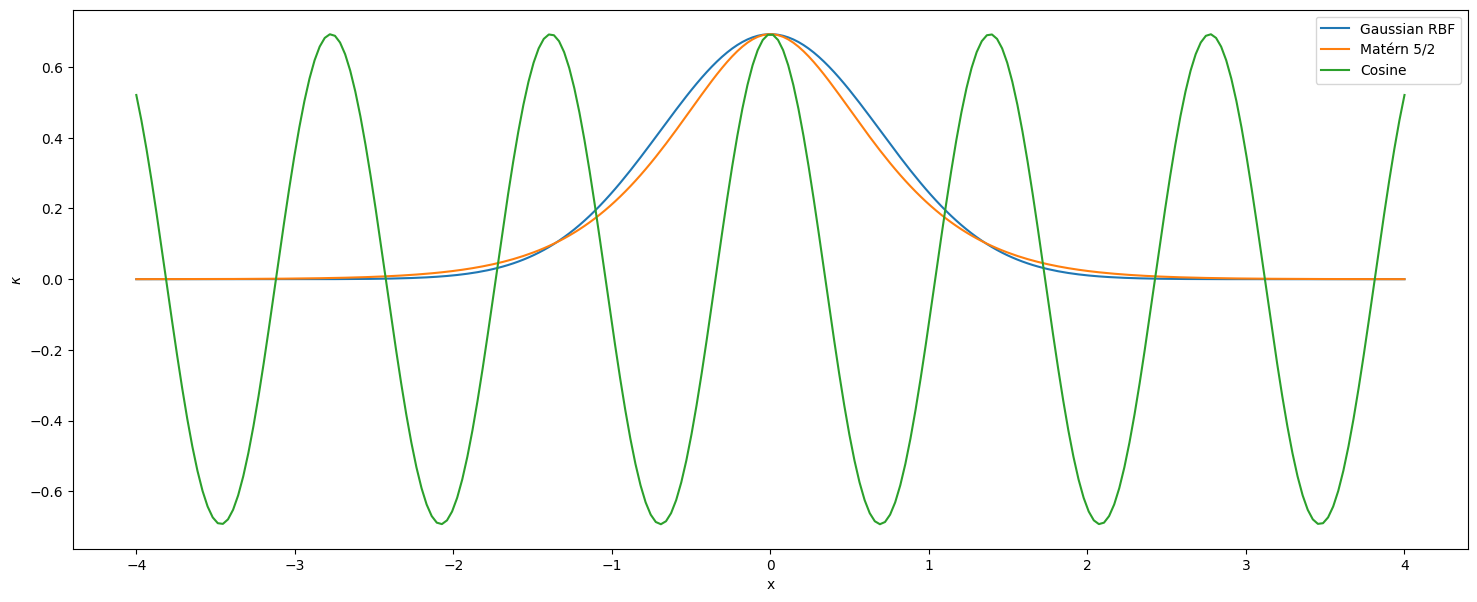

In [125]:
# Our sample space : 100 samples in the interval [-4,4]
X = torch.linspace(-4.,4.,250)

# RBF kernel
k_R = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel())
C_R = k_R(X, torch.tensor([[0.]])).to_dense().detach().numpy()

# Matern 5/2
k_M = gpt.kernels.ScaleKernel(gpt.kernels.MaternKernel(nu=2.5))
C_M = k_M(X, torch.tensor([[0.]])).to_dense().detach().numpy()

# Cosine
k_C = gpt.kernels.ScaleKernel(gpt.kernels.CosineKernel())
C_C = k_C(X, torch.tensor([[0.]])).to_dense().detach().numpy()

plt.figure(figsize=(18,7))
plt.plot(X, C_R, X, C_M, X, C_C);
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.legend(labels=["Gaussian RBF", "Matérn 5/2", "Cosine"]);

Not every kernel has the same set of parameters. Some kernels are not parameterised by a lengthscale, for example, like the `Linear` kernel which only has a list of variances corresponding to each linear component

In [126]:
L=gpt.kernels.LinearKernel(ard_num_dims=3)
L.variance

tensor([[0.6931, 0.6931, 0.6931]], grad_fn=<SoftplusBackward0>)

Likewise, not every kernel is stationary. In the case of the Gaussian RBF, or Matérn kernels, the kernel can be written $\kappa(x,x') = f(x-x')$, however this is not true for, e.g., the polynomial covariance function, which is defined as $k(x,x') = (x^\top x'+c)^d$. This means that the covariance between points depends on the input points themselves.

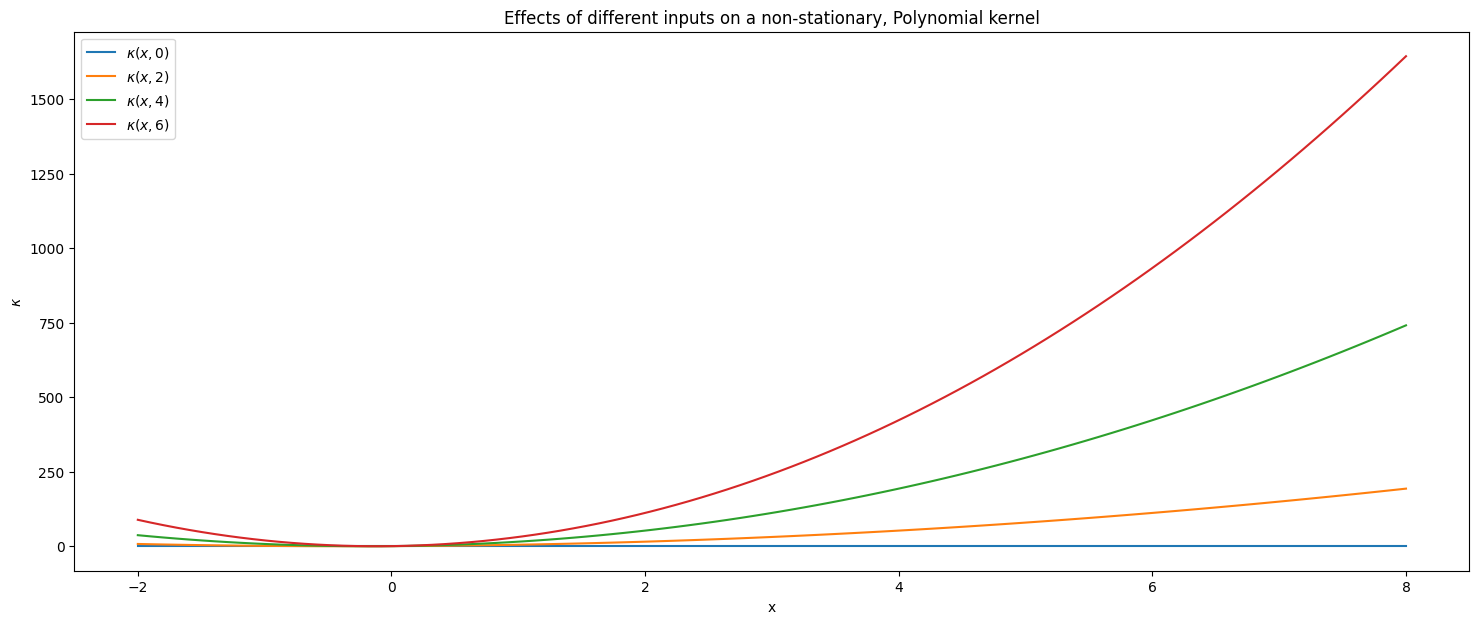

In [127]:
# Our sample space : 100 samples in the interval [-2,8]
X = torch.linspace(-2., 8., 100)[:,None]

# Note that the Polynomial kernel is defined:
#   k(x,x') = (xTx'+c)^d

# We define our polynomial kernel
k_b = gpt.kernels.ScaleKernel(gpt.kernels.PolynomialKernel(power=2))


plt.figure(figsize=(18,7))

x_s = [0., 2., 4., 6.] # values of x'
# Loop through values of x'
for x_ in x_s:
    # Evaluate kernel at k(x,x')
    K_B = k_b(X, torch.tensor([[x_]])).to_dense().detach().numpy()
    # Plot covariance vector
    plt.plot(X, K_B)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.title("Effects of different inputs on a non-stationary, Polynomial kernel")
plt.legend(labels=["$\kappa(x,0)$", "$\kappa(x,2)$", "$\kappa(x,4)$", "$\kappa(x,6)$"]);

How might we interpret the correlation structure indicated in the above plot?

# Sampling from GP priors

As previously discussed the covariance function determines the prior Gaussian process, let's sample from a prior GP to show how the covariance effects the resulting function space.

In [128]:
# We will use the simplest form of GP model, exact inference
# The model is defined by mean and covariance modules

class ExactGPModelRBF(gpt.models.ExactGP): # Define a class. of GPs
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModelRBF, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.ZeroMean(input_size=1)
        self.covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpt.likelihoods.GaussianLikelihood()
model = ExactGPModelRBF(torch.tensor([]), torch.tensor([]), likelihood) # Generate the model with no training data
model.covar_module.base_kernel.lengthscale = 1 # Set the RBF kernel lengthscale to 1

In [129]:
model.covar_module.base_kernel.kernels[0]

AttributeError: 'RBFKernel' object has no attribute 'kernels'

In [ ]:
# Set the model and likelihood to evaluate mode
model.eval()
likelihood.eval()

# Plot samples from the prior
x0=torch.linspace(-5,5,100) # parameter space
plt.plot(model(x0).sample(sample_shape=torch.Size([10],)).T); # plot samples from the GP prior

Above we set the kernel lengthscale to 1. What happens if we make the lengthscale larger?

In [ ]:
model.covar_module.base_kernel.lengthscale = 3
plt.plot(model(x0).sample(sample_shape=torch.Size([10],)).T);

Or shorter?

In [ ]:
model.covar_module.base_kernel.lengthscale = 0.5
plt.plot(model(x0).sample(sample_shape=torch.Size([10],)).T);

# Exercise

Re-write the code above to sample from GP priors with different covariance functions and visualise the results. You can also try combining covariance functions and changing the kernel parameters.

A nice tool for visualising different kernels: https://www.infinitecuriosity.org/vizgp/

Changing the kernel alters the GP prior and you can place points to see the resulting predicted function.

## 3. 1D Gaussian process regression



We've looked at Gaussian process priors and covariance functions. Let's try some Gaussian process regression!

Here we will generate data from a toy function and use it to train a GP emulator.

# Example 1: 1D input, 1D output

Creating an emulator for the function $$f(\theta)=sin(4\theta)+\theta$$ from noisy observations.

$$\theta \in [0,1]$$

Our observational model is $$y_i=f(\theta_i)+\epsilon_i$$ where $$\epsilon_i \sim N(0,\sigma_o^2)$$.

We aim to train a gaussian process emulator, $g$, such that $$g(\theta) \approx f(\theta)$$

The hyper-parameters we seek to learn are the GP hyper-parameters and the observation noise variance, $\sigma_o^2$.

In [ ]:
def oneD_func(theta): # define f(theta)
    return torch.sin(4*theta) + theta

In [ ]:
# Set observation upper and lower bounds
lb= -1. # lower bound
ub = 1. # upper bound

p = 5 # Number of observations (more means better emulation)

p2=50

theta_train = torch.linspace(lb,ub,p) # Generate training inputs

y_train=oneD_func(theta_train)

theta_test = torch.linspace(lb,ub,p2) # Generate test inputs

y_test= oneD_func(theta_train)

Let's define a GP model with GPyTorch. We'll use an RBF kernel and a zero mean function.

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpt.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.ZeroMean(input_size=1)
        self.covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpt.likelihoods.GaussianLikelihood()
model = ExactGPModel(theta_train, y_train, likelihood) #By including the training data we generate a posterior GP

likelihood.eval()
model.eval()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [ ]:
# Train-test split randomises the data
#here we sort the test data back from min -> max
theta_test=theta_test.sort()[0]

# Predict
predictions_untrained=likelihood(model(theta_test))

We can plot our predictions and uncertainty against the real function.

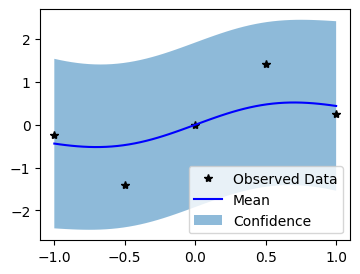

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = predictions_untrained.confidence_region()
    # Plot training data as black stars
    ax.plot(theta_train,y_train, 'k*')
    # Plot predictive means as blue line
    ax.plot(theta_test, predictions_untrained.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(theta_test, lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([0, 3])

    ax.legend(['Observed Data', 'Mean', 'Confidence'])

We can also sample from the GP posterior:

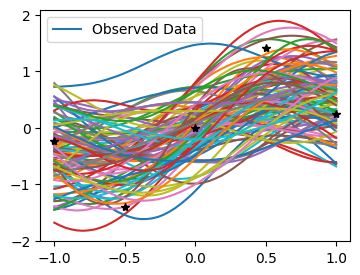

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    #ax.set_ylim([0, 3])
    ax.plot(theta_test,model(theta_test).sample(sample_shape=torch.Size([100],)).T);
    # Plot training data as black stars
    ax.plot(theta_train,y_train, 'k*')

    ax.legend(['Observed Data'])

Though our GP posterior mean is very vaguely approximating the shape of the observed data, our predictions aren't very good. Let's optimise the GP hyper-parameters and the observation noise.

In [ ]:
training_iter =500

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(theta_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/500 - Loss: 1.384   lengthscale: 0.693   noise: 0.693
Iter 2/500 - Loss: 1.367   lengthscale: 0.644   noise: 0.644
Iter 3/500 - Loss: 1.350   lengthscale: 0.598   noise: 0.598
Iter 4/500 - Loss: 1.334   lengthscale: 0.554   noise: 0.555
Iter 5/500 - Loss: 1.320   lengthscale: 0.513   noise: 0.514
Iter 6/500 - Loss: 1.308   lengthscale: 0.474   noise: 0.476
Iter 7/500 - Loss: 1.300   lengthscale: 0.438   noise: 0.440
Iter 8/500 - Loss: 1.295   lengthscale: 0.405   noise: 0.408
Iter 9/500 - Loss: 1.294   lengthscale: 0.376   noise: 0.380
Iter 10/500 - Loss: 1.296   lengthscale: 0.352   noise: 0.356
Iter 11/500 - Loss: 1.299   lengthscale: 0.332   noise: 0.337
Iter 12/500 - Loss: 1.302   lengthscale: 0.316   noise: 0.324
Iter 13/500 - Loss: 1.304   lengthscale: 0.305   noise: 0.317
Iter 14/500 - Loss: 1.304   lengthscale: 0.297   noise: 0.314
Iter 15/500 - Loss: 1.303   lengthscale: 0.293   noise: 0.314
Iter 16/500 - Loss: 1.302   lengthscale: 0.292   noise: 0.317
Iter 17/500 - Los

In [ ]:
model.eval()
likelihood.eval()
predictions_trained=likelihood(model(theta_test))

px = torch.distributions.Normal(predictions_trained.mean, predictions_trained.stddev)
sample2 = px.sample()

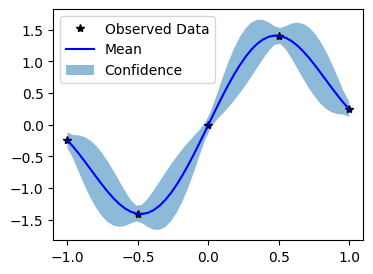

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = predictions_trained.confidence_region()
    # Plot training data as black stars
    ax.plot(theta_train,y_train, 'k*')
    # Plot predictive means as blue line
    ax.plot(theta_test, predictions_trained.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(theta_test, lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([0, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

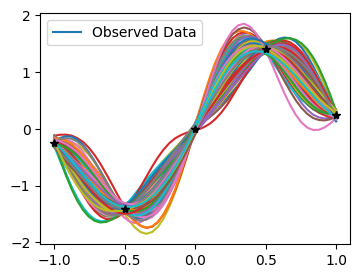

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    #ax.set_ylim([0, 3])
    ax.plot(theta_test,model(theta_test).sample(sample_shape=torch.Size([100],)).T);
    # Plot training data as black stars
    ax.plot(theta_train,y_train, 'k*')

    ax.legend(['Observed Data'])

What happens outside of our training range?

In [ ]:
q=200
theta2 = torch.linspace(-2*ub,2*ub,q) # Generate theta={theta_i}

predictions_extended=likelihood(model(theta2))

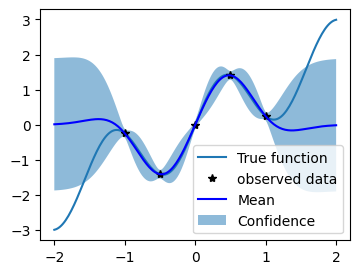

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = predictions_extended.confidence_region()
    # Plot training data as black stars
    ax.plot(theta2,oneD_func(theta2))
    ax.plot(theta_train,y_train, 'k*')
    # Plot predictive means as blue line
    ax.plot(theta2, predictions_extended.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(theta2, lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([0, 3])
    ax.legend(['True function','observed data', 'Mean', 'Confidence'])

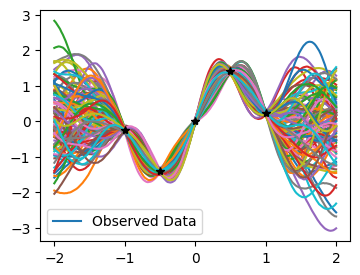

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    #ax.set_ylim([0, 3])
    ax.plot(theta2,model(theta2).sample(sample_shape=torch.Size([100],)).T);
    # Plot training data as black stars
    ax.plot(theta_train,y_train, 'k*')

    ax.legend(['Observed Data'])

# Emulating a cardiac digital twin

In this section we'll put generate simulations from the Naghavi et al. model of left ventricular contractility using the Modular Circ python library. We'll then train a Gaussian process emulator of the model and use it to perform global sensitivity analysis.

The Naghavi model is a cardiovascular model described in Rapid Estimation of Left Ventricular Contractility with a Physics-Informed Neural Network Inverse Modeling Approach (https://arxiv.org/html/2401.07331v1). The model is comprised of the following components:

LA: linear time-varying elastance model (6 parameters)
MV: non-ideal diode model (1 parameter)
LV: linear time-varying elastance model (5 parameters)
AV: non-ideal diode model (1 parameter)
Aorta: RC Windkessel model (2 parameters)
Vena cava: RC Windkessel model (2 parameters)
Total set of parameters sums up to 17.



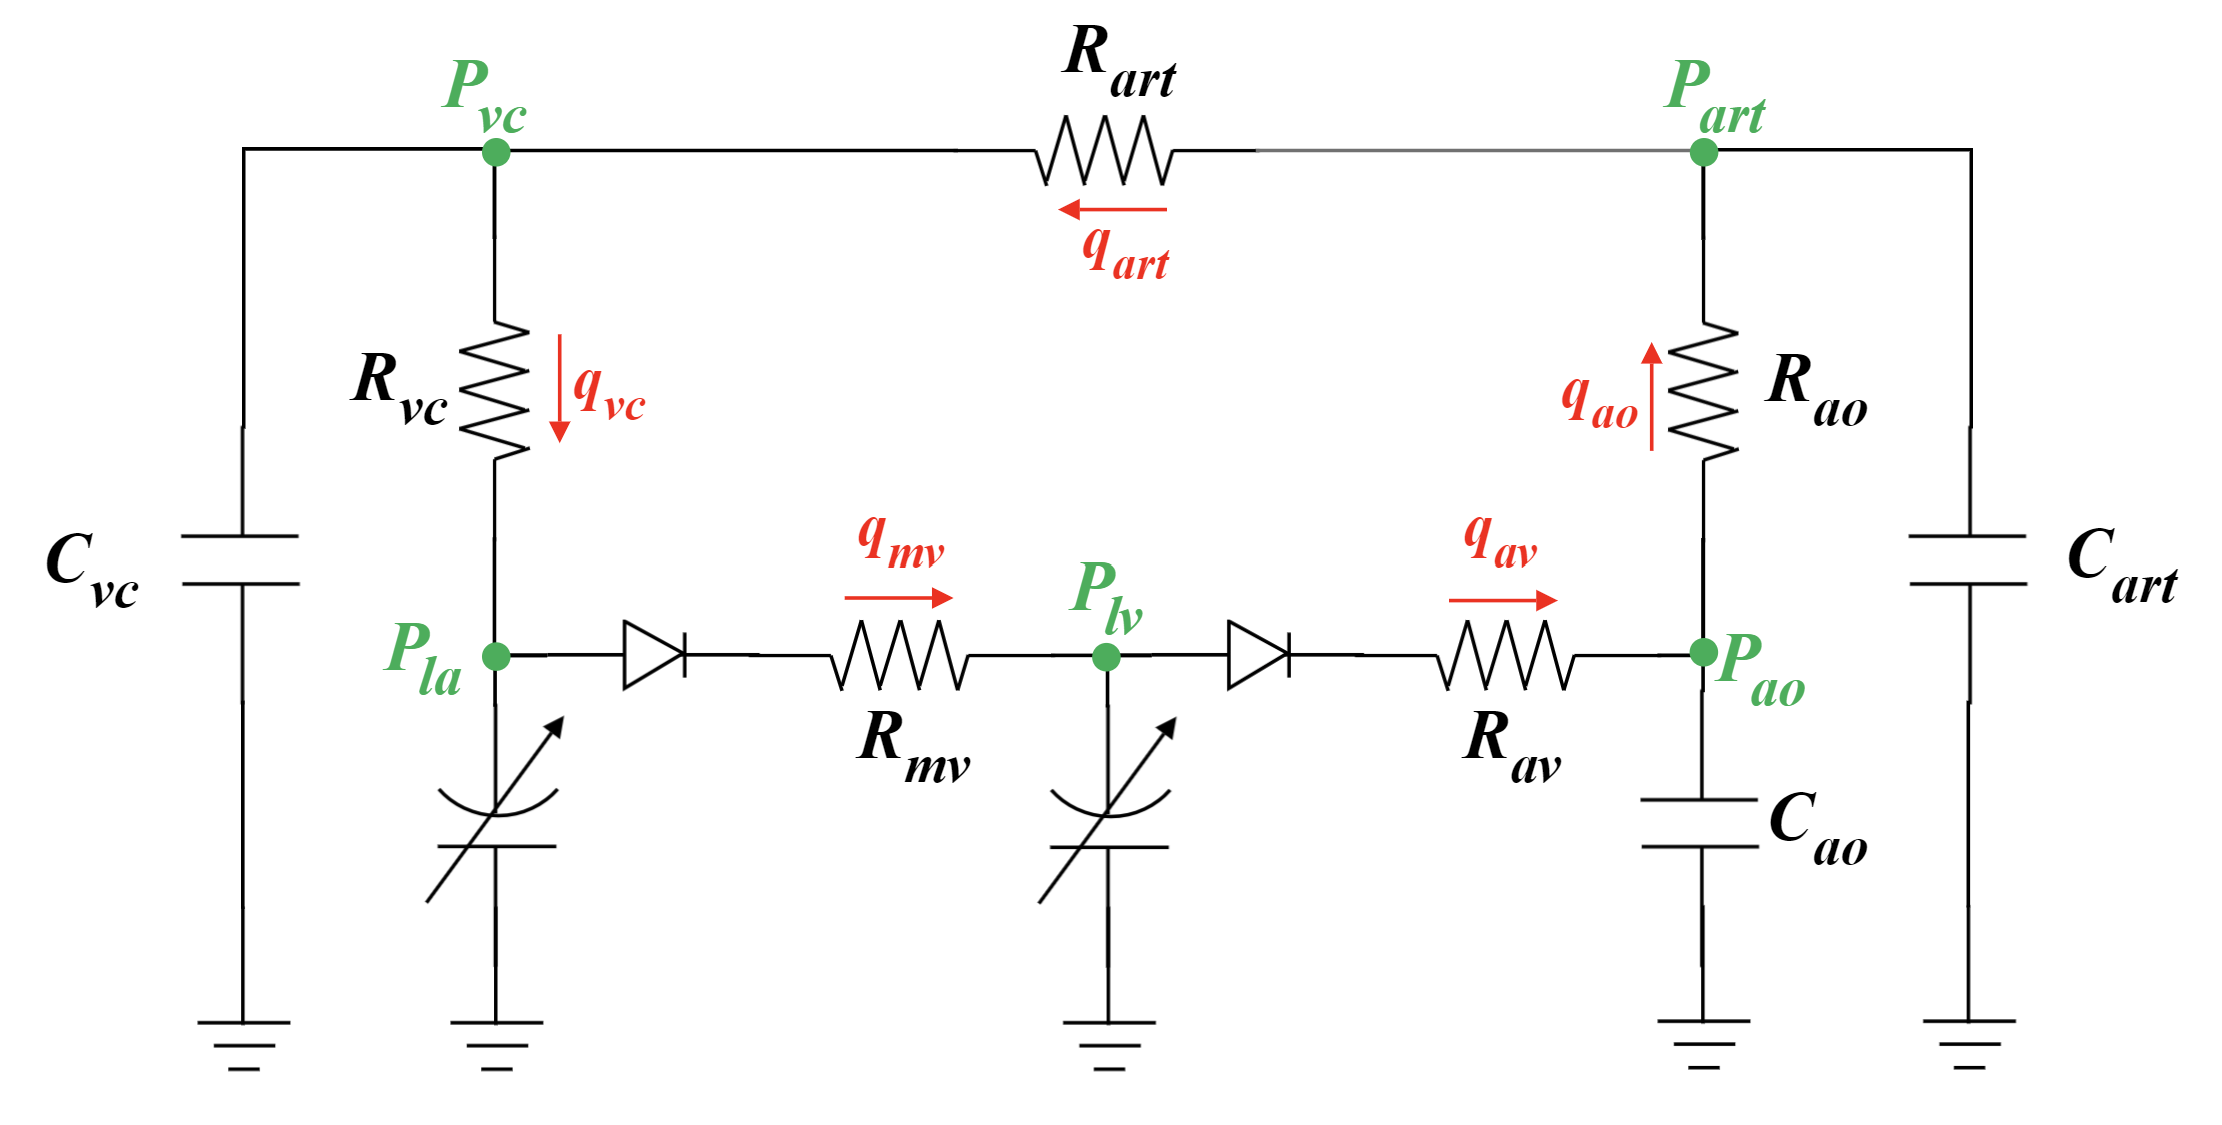

In [ ]:
url = 'https://arxiv.org/html/2401.07331v1/extracted/5346203/Circuit.png'
with urllib.request.urlopen(url) as url:
    img = Image.open(BytesIO(url.read()))

display(img)

To run the model using modular circ we need to load a json file that includes the parameters. To view the file click on the file button on the left. For each parameter you will find a reference value and for those parameters that are varying there is a proportional range within which to vary them.

In this case were are only varying 6 parameters of a possible 17. One might interpret this as "personalising" the model for a patient with some known parameter values.

In [ ]:
!wget https://raw.githubusercontent.com/cwlanyon/CardiacDTWorkshop/refs/heads/main/parameters_01.json

--2025-10-01 10:51:38--  https://raw.githubusercontent.com/cwlanyon/CardiacDTWorkshop/refs/heads/main/parameters_01.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1660 (1.6K) [text/plain]
Saving to: ‘parameters_01.json.1’

parameters_01.json. 100%[===================>]   1.62K  --.-KB/s    in 0s      

2025-10-01 10:51:38 (18.5 MB/s) - ‘parameters_01.json.1’ saved [1660/1660]



Next we import the Naghavi model and the batch runner function. This will allow us to sample from the parameter space and run the model for each sample.

In [ ]:
from ModularCirc.Models.NaghaviModel import NaghaviModel, NaghaviModelParameters, TEMPLATE_TIME_SETUP_DICT

In [ ]:
from ModularCirc import BatchRunner

In [ ]:
br = BatchRunner('LHS', 0) # Initialise the batch runner

In [ ]:
br.setup_sampler('parameters_01.json') #Set up the sampler with our parameters

In [ ]:
br.sample(200) # Take samples from the parameter space

In [ ]:
br.samples

,ao.c,art.r,art.c,ven.c,lv.E_act,lv.k_pas,ao.r,ao.l,ao.v_ref,art.l,...,la.tau,la.t_max,lv.E_pas,lv.v_ref,lv.delay,lv.t_tr,lv.tau,lv.t_max,T,v_tot
0,0.332045,757.857450,2.594385,100.630484,1.967801,0.007628,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
1,0.282590,1402.146582,2.346846,74.691274,2.507762,0.021362,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
2,0.246214,1394.811081,2.434055,153.177926,2.177052,0.015801,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
3,0.164550,875.122384,1.934575,123.886165,2.299941,0.012728,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
4,0.330577,1021.591814,3.015042,107.985773,4.474717,0.012990,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.426821,1491.807557,2.491186,184.685335,3.737931,0.019146,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
196,0.231131,1191.637464,3.161097,73.550706,2.388777,0.013481,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
197,0.172097,1016.049188,2.012291,171.289222,3.586650,0.014681,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
198,0.384575,1260.361346,2.924076,186.923089,3.266667,0.011936,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000


In [ ]:
TEMPLATE_TIME_SETUP_DICT

{'name': 'TimeTest',
 'ncycles': 30,
 'tcycle': 1000.0,
 'dt': 1.0,
 'export_min': 1}

In [ ]:
map_ = {
    'lv.t_tr' : ['lv.t_tr',],
    'la.t_tr' : ['la.t_tr',],
    'la.delay' : ['la.delay',],
    'lv.tau' : ['lv.tau',],
    'la.tau' : ['la.tau',],
    'lv.t_max' : ['lv.t_max',],
    'la.t_max' : ['la.t_max',],
}
br.map_sample_timings(
    ref_time=1000.,
    map=map_
    )

In [ ]:
br.map_vessel_volume()
br._samples[['ao.v', 'art.v', 'ven.v']].describe().T

,count,mean,std,min,25%,50%,75%,max
ao.v,200.0,11.888618,5.010956,4.379832,8.584829,10.663754,14.579428,30.351670
art.v,200.0,119.902945,50.745345,43.211742,78.858879,110.218316,151.408823,264.975996
ven.v,200.0,4868.208437,53.180878,4710.220706,4835.143149,4877.290429,4909.215697,4950.702816


In [ ]:
br.setup_model(model=NaghaviModel, po=NaghaviModelParameters, time_setup=TEMPLATE_TIME_SETUP_DICT)

In [ ]:
import os

In [ ]:
path = os.getcwd()
path

'/content'

In [115]:
os.system(f'mkdir -p {path+ "/Outputs/Out_01"}')
test = br.run_batch(n_jobs=2, output_path=path+'/Outputs/Out_01')

100%|██████████| 200/200 [06:18<00:00,  1.89s/it]


In [ ]:
test[0].min(axis=0).values

array([ 1.41330885e+02,  1.21131784e+03,  3.40336923e+03,  2.65788850e+01,
        1.85292095e+02,  2.98002747e+00,  0.00000000e+00,  1.24473911e+02,
        1.19996758e+02,  1.76102400e-02,  5.99588915e+00,  1.49265511e-01,
        9.59464509e-01, -9.74776341e-01,  0.00000000e+00,  7.20000000e+03])

In [ ]:
max_values = torch.zeros(len(test),test[0].shape[1])
min_values = torch.zeros(len(test),test[0].shape[1])
for i in range(len(test)):
  max_values[i]=torch.tensor(test[i].max(axis=0).values)
  min_values[i]=torch.tensor(test[i].min(axis=0).values)

diff = max_values-min_values

In [ ]:
max_values= (max_values -max_values.mean(axis=0))/max_values.std(axis=0)
min_values= (min_values -min_values.mean(axis=0))/min_values.std(axis=0)
diff = (diff -diff.mean(axis=0))/diff.std(axis=0)

In [ ]:
max_values

tensor([[ 1.0904, -0.1876, -0.4607,  ...,  0.3305,  1.8522, -1.2940],
        [-0.7327, -0.8045,  0.7915,  ...,  2.4718, -2.2081, -0.0149],
        [-0.9753, -0.7789,  0.8014,  ..., -0.1298, -0.2197,  0.4114],
        ...,
        [-1.0990, -0.9163,  1.1108,  ..., -0.2640,  0.1460, -0.8676],
        [ 0.7304,  0.1668, -0.1238,  ..., -1.0162,  0.2371,  0.4114],
        [ 1.3525,  0.3774, -0.8818,  ..., -0.5173,  1.6933, -1.2940]])

In [ ]:
ind = 0
test[ind].loc[ind].describe()

,v_ao,v_art,v_ven,v_la,v_lv,p_lv,q_av,p_ao,p_art,q_ao,p_ven,q_art,p_la,q_ven,q_mv,T
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,159.508895,1256.172996,3430.823542,123.490645,227.003922,62.919338,0.174982,179.219606,137.286078,0.174723,6.268712,0.172879,4.699380,0.174370,0.174576,7600.000000
std,21.665787,25.813201,31.373763,54.214821,45.650092,113.821475,0.510608,65.249636,9.949640,0.267060,0.311772,0.013347,3.129758,0.345551,0.372120,231.286489
min,141.330885,1211.317837,3403.369229,26.578885,185.292095,2.980027,0.000000,124.473911,119.996758,0.017610,5.995889,0.149266,0.959465,-0.974776,0.000000,7200.000000
25%,145.194503,1233.198233,3404.923308,72.743571,187.812026,3.704054,0.000000,136.109755,128.430507,0.020041,6.011333,0.161328,2.826763,0.133654,0.000000,7400.000000
50%,149.863527,1257.875882,3413.401281,153.775119,214.495679,4.523007,0.000000,150.171192,137.942452,0.031988,6.095581,0.173921,4.196342,0.204285,0.099219,7600.000000
75%,164.243793,1280.872519,3457.525388,168.827271,235.037195,32.232504,0.000000,193.479434,146.806453,0.188149,6.534058,0.185599,4.852582,0.381893,0.150970,7800.000000
max,219.563450,1291.659334,3491.920042,176.645730,325.406411,365.925885,2.133777,360.082548,150.964207,0.946235,6.875849,0.191010,15.083972,0.626531,1.955858,8000.000000


In [ ]:
import matplotlib.pyplot as plt

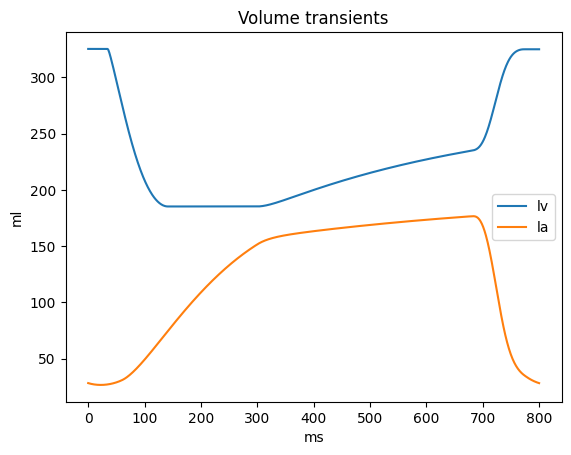

In [ ]:
t = test[ind].loc[ind]['T'] - test[ind].loc[ind]['T'].loc[0]

fig, ax = plt.subplots()

ax.plot(t, test[ind].loc[ind]['v_lv'], label='lv')
ax.plot(t, test[ind].loc[ind]['v_la'], label='la')

ax.set_xlabel('ms')
ax.set_ylabel('ml')

ax.legend()
ax.set_title('Volume transients')

plt.show()

In [ ]:
theta = torch.tensor(br.samples.values)[:,0:6]

In [ ]:
theta = (theta-theta.mean(axis=0))/theta.std(axis=0)

In [ ]:
# Use train_test_split to split into training and desting data
theta_train, theta_test, y_train, y_test = train_test_split(
    theta, #inputs
    diff[:,0], #outputs
    test_size=0.2, # proportion (or integer valued) of total data set used for testing
)

In [ ]:
y_train.shape

torch.Size([160])

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpt.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.ZeroMean(input_size=1)
        self.covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel(ard_num_dims=6))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpt.likelihoods.GaussianLikelihood()
model = ExactGPModel(theta_train, y_train, likelihood)

likelihood.eval()
model.eval()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [ ]:
training_iter =500

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(theta_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #i + 1, training_iter, loss.item(),
        #model.covar_module.base_kernel.lengthscale.item(),
        #model.likelihood.noise.item()
    #))
    optimizer.step()

In [ ]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
likelihood(model(theta_test)).mean

tensor([-0.7407,  1.1437,  0.9174,  0.2506, -0.9038, -1.3314, -0.9208, -1.2722,
        -0.0536, -1.6326,  1.9928,  0.8663, -0.4456,  0.3260,  1.1168, -0.4882,
         0.2727, -0.5505,  0.8969, -1.1368, -1.3329, -0.8501,  0.7040, -1.0914,
        -0.8235,  2.8774,  1.1478, -0.0465,  0.4171, -0.3473,  0.1809, -0.3752,
        -1.4245,  0.6495, -0.6396,  1.8043, -0.9724,  1.2654,  0.9030,  3.7125],
       dtype=torch.float64, grad_fn=<ViewBackward0>)

In [ ]:
y_test

tensor([-0.7425,  1.1707,  0.9384,  0.2656, -0.8951, -1.3500, -0.9420, -1.2881,
        -0.0517, -1.6430,  1.9881,  0.9005, -0.4858,  0.3332,  1.1101, -0.4895,
         0.2832, -0.5335,  0.8926, -1.1418, -1.3398, -0.8378,  0.7293, -1.0975,
        -0.8306,  2.9441,  1.1294, -0.0556,  0.4158, -0.3790,  0.2229, -0.4370,
        -1.4257,  0.6725, -0.6278,  1.7622, -0.9773,  1.2657,  0.9037,  3.8204])

In [ ]:
((likelihood(model(theta_test)).mean-y_test)**2).mean(axis=0)

tensor(0.0008, dtype=torch.float64, grad_fn=<MeanBackward1>)

In [ ]:
y_test.var(axis=0)

tensor(0.8791)

# 4. Global Sensitivity Analysis

In [ ]:
# Install the SALib library to perform GSA
!pip install SALib

In [ ]:
#Import libraries for sensitivity analysis

import scipy.stats.qmc as qmc
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

In [ ]:
nDim = theta_train.shape[1]
boundsMaxMin = []
for i in range(nDim): # Calculates the max and min bounds of the parameters
    boundsMaxMin.append([np.min(theta_train[:,i].detach().numpy()),np.max(theta_train[:,i].detach().numpy())])

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': ['ao.c',	'art.r',	'art.c',	'ven.c',	'lv.E_act',	'lv.k_pas'],
    'bounds': boundsMaxMin
}

# Generate samples via a saltelli sample
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=likelihood(model((data1))).mean#use the emulator to predict the f at the sampled parameter values

In [ ]:
Si = []
nMod = 1

for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean.detach().numpy(), print_to_console=True,calc_second_order=True))

Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

                ST   ST_conf
ao.c      0.002972  0.000331
art.r     0.031613  0.004347
art.c     0.052742  0.005801
ven.c     0.240623  0.022414
lv.E_act  0.044015  0.005599
lv.k_pas  0.663256  0.057644
                S1   S1_conf
ao.c      0.002359  0.004319
art.r     0.024510  0.013204
art.c     0.046052  0.022378
ven.c     0.209294  0.039688
lv.E_act  0.035581  0.017783
lv.k_pas  0.642030  0.063811
                            S2   S2_conf
(ao.c, art.r)         0.000774  0.006550
(ao.c, art.c)         0.000819  0.006551
(ao.c, ven.c)         0.000606  0.007413
(ao.c, lv.E_act)      0.001419  0.006550
(ao.c, lv.k_pas)      0.000329  0.007600
(art.r, art.c)       -0.000106  0.020540
(art.r, ven.c)        0.002613  0.024248
(art.r, lv.E_act)     0.002563  0.022089
(art.r, lv.k_pas)    -0.000460  0.024415
(art.c, ven.c)        0.006398  0.025691
(art.c, lv.E_act)     0.003897  0.026022
(art.c, lv.k_pas)     0.003876  0.038561
(ven.c, lv.E_act)     0.004051  0.060052
(ven.c, lv.k_pas)   

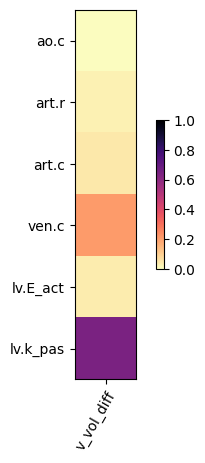

In [ ]:
inputs =  ['ao.c',	'art.r',	'art.c',	'ven.c',	'lv.E_act',	'lv.k_pas']
outputs = ['v_vol_diff']
fig, ax = plt.subplots()
im = ax.imshow(Si_first,cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)